In [15]:
%reset -f
%matplotlib inline
import pandas as pd
import numpy as np
import pylab as pl
from sys import stdout
from time import time
from tick.simulation import SimuCoxRegWithCutPoints
from tick.preprocessing.features_binarizer import FeaturesBinarizer
from tick.inference import CoxRegression
from binacox import compute_score, auto_cutoff, get_groups, get_m_1, \
                    get_m_2, p_value_cut, bootstrap_cut_max_t
from prettytable import PrettyTable
from matplotlib import rc
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)

## Generate data

In [89]:
n_samples = 3000
n_features = 50
n_cut_points = 3
cov_corr = .5
sparsity = .2
seed = 2
simu = SimuCoxRegWithCutPoints(n_samples=n_samples, n_features=n_features, 
                               seed=seed, verbose=True, n_cut_points=n_cut_points,
                               shape=2, scale=.1, cov_corr=cov_corr, sparsity=sparsity)
X, Y, delta, cut_points, beta_star, S = simu.simulate()

-----------------------------------------------------
Launching simulation using SimuCoxRegWithCutPoints...
Done simulating using SimuCoxRegWithCutPoints in 1.38e-01 seconds.


### Visualization

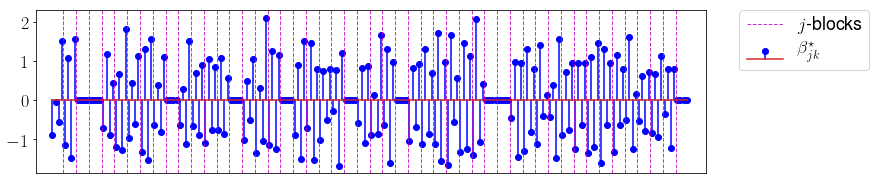

In [90]:
save_figures = False

if n_features == 2:
    fig = pl.figure(figsize=(12, 8))
    ax = fig.add_subplot(111)
    pl.scatter(*X[delta == 0].T, c=Y[delta == 0], cmap='RdBu', 
               marker="x", label=r"censoring $(z_i = c_i)$")
    pl.scatter(*X[delta == 1].T, c=Y[delta == 1], cmap='RdBu', 
               marker="o", label=r"failure $(z_i = t_i)$")
    cb = pl.colorbar()
    cb.ax.tick_params(labelsize=15)
    cb.set_label(r'$Z = T \wedge C$', rotation=0, fontsize=20)
    cb.ax.get_yaxis().labelpad = 50

    y_min, y_max = ax.get_ylim()
    ax.set_ylim([y_min, y_max])
    cut_points_y = cut_points['0'][1:-1]
    ax.plot(cut_points['0'][1:-1], np.repeat(y_min, len(cut_points_y)), 
            'g^', ms=20, label='cut-points')
    for cut_p in cut_points_y:
        ax.axvline(cut_p, ls='--', c='g', alpha=.8, lw=1)
    x_min, x_max = ax.get_xlim()
    ax.set_xlim([x_min, x_max])
    cut_points_x = cut_points['1'][1:-1]
    ax.plot(np.repeat(x_min, len(cut_points_x)), cut_points_x,
            marker=(3, 0, 3*90), c='g', ms=20)
    for cut_p in cut_points['1'][1:-1]:
        ax.axhline(cut_p, ls='--', c='g', alpha=.8, lw=1)

    ax.tick_params(labelsize=15)
    pl.tick_params(axis='x', which='both', top='off')
    ax.set_xlabel(r'$x_{\bullet, 1}$', fontsize=22)
    ax.set_ylabel(r'$x_{\bullet, 2}$', fontsize=22, rotation=0)
    ax.get_yaxis().labelpad = 20
    legend = pl.legend(prop={'size': 15})
    legend.legendHandles[0]._legmarker.set_markersize(10)
    if save_figures:
        pl.savefig('./figures/data.pdf', bbox_inches='tight')
    pl.show()

fig = pl.figure(figsize=(12, 3))
ax = fig.add_subplot(111)
ax.stem(beta_star, 'b', markerfmt='bo', label=r"$\beta^\star_{jk}$")
ax.set_xlim([-5, len(beta_star) + 5])
n_coeffs_cum = 0
for i in range(n_features - 1):
    n_coeffs = len(cut_points[str(i)]) - 1
    label = ''
    if i == 0:
        label = r'$j$-blocks'
    ax.axvline(n_coeffs_cum + n_coeffs - .5, c='m', 
               ls='--', alpha=.8, lw=1, label=label) 
    n_coeffs_cum += n_coeffs
    
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')
pl.yticks(fontsize = 18)
ax.yaxis.labelpad = 20 
ax.legend(bbox_to_anchor=(1.05, 1), loc=2,borderaxespad=0., 
          numpoints=1, markerscale=.5, fontsize=18)
if save_figures:
    pl.savefig('./figures/beta_star.pdf', bbox_inches='tight')
pl.show()

### Binarize features

In [91]:
tic = time()
n_cuts = 50
binarizer = FeaturesBinarizer(n_cuts=n_cuts)
X_bin = binarizer.fit_transform(X)
tac = time()
print("Done binarizing in %.2e seconds." % (tac - tic))

blocks_start = binarizer.blocks_start
blocks_length = binarizer.blocks_length
boundaries = binarizer.boundaries

Done binarizing in 1.14e-01 seconds.


### Cross-validation

In [92]:
solver = 'agd'
learner = CoxRegression(penalty='binarsity', tol=1e-5,
                        solver=solver, verbose=False, 
                        max_iter=100, step=0.3,
                        blocks_start=blocks_start,
                        blocks_length=blocks_length,
                        warm_start=True)
learner._solver_obj.linesearch = False

n_folds = 10
grid_size = 20
grid_C = np.logspace(1, 5, grid_size)
scores_cv = pd.DataFrame(columns=['ll_test', 'test_std'])
tic = time()
for i, C in enumerate(grid_C):
    stdout.write("\rCV: %d%%" % ((i + 1) * 100 / grid_size))
    stdout.flush()
    scores_cv.loc[i] = compute_score(learner, X, X_bin, Y, delta, blocks_start, 
                                     blocks_length, boundaries, C, n_folds, scoring="log_lik_refit")
tac = time()
idx_min = scores_cv.ll_test.argmin()
C_best = grid_C[idx_min]
idx_chosen = min([i for i, j in enumerate(list(scores_cv.ll_test <= scores_cv.ll_test.min() 
                                               + scores_cv.test_std[idx_min])) if j])
C_chosen = grid_C[idx_chosen]
print("\nDone cross-validating in %.2e seconds." % (tac - tic))
print("C_chosen = %.1f" % C_chosen)

CV: 100%
Done cross-validating in 8.69e+01 seconds.
C_chosen = 112.9


### Learning curves

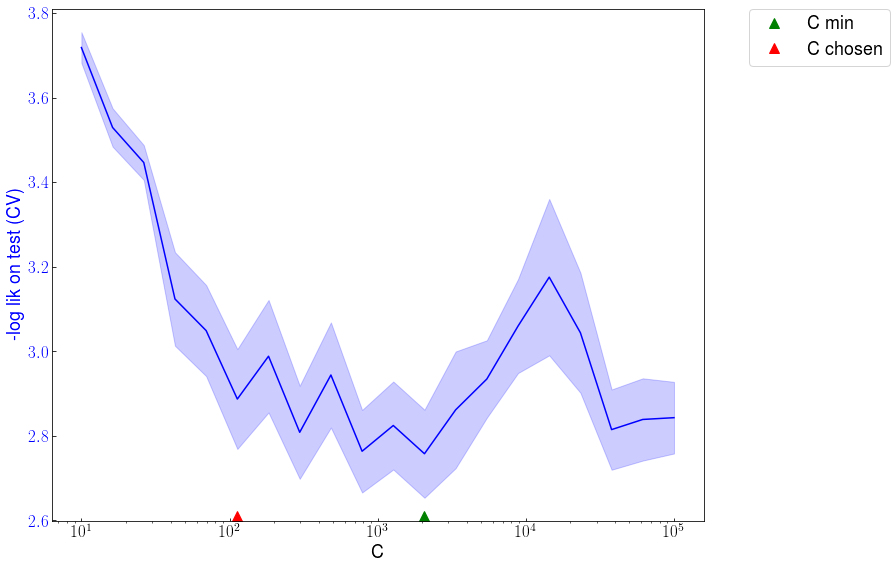

In [83]:
def color_y_axis(ax, color):
    for t in ax.get_yticklabels():
        t.set_color(color)
        
fig = pl.figure(figsize=(10, 8))
ax = fig.add_subplot(111)
eps = scores_cv.test_std / np.sqrt(n_folds) * 1.96
pl.plot(grid_C, scores_cv.ll_test, color='b', label='')
pl.fill_between(grid_C,  scores_cv.ll_test - eps, 
                scores_cv.ll_test + eps,  color='b', alpha=0.2)
color_y_axis(ax, 'b')
ax.set_ylabel('-log lik on test (CV)', fontsize=18, color='b')
ax.tick_params(axis='both', which='major', direction='in',
               labelsize=17)
y_min, y_max = ax.get_ylim()
ax.set_ylim([y_min, y_max])
ax.plot(C_best, y_min, 'g^', ms=20, label='C min')
ax.plot(C_chosen, y_min, 'r^', ms=20, label='C chosen')
ax.legend(bbox_to_anchor=(1.07, 1), loc=2,borderaxespad=0., 
          numpoints=1, markerscale=.5, fontsize=18)
ax.set_xlabel('C', fontsize=18)
pl.xscale('log')
pl.tight_layout()
if save_figures:
    pl.savefig('./figures/cv.pdf', bbox_inches='tight')
pl.show()

## Final estimation

In [84]:
learner.C = C_chosen
learner.fit(X_bin, Y, delta)
coeffs = learner.coeffs

all_groups = list()
cut_points_estimates = {}
b_star = np.zeros(len(coeffs))
for j, start in enumerate(blocks_start):
    coeffs_j = coeffs[start:start + blocks_length[j]]
    all_zeros = not np.any(coeffs_j)
    if all_zeros:
        cut_points_estimate_j = np.array([-np.inf, np.inf])
        groups_j = np.array(blocks_length[j] * [0])
    else:
        groups_j = get_groups(coeffs_j)  
        jumps_j = np.where(groups_j[1:] - groups_j[:-1] != 0)[0] + 1
        if len(jumps_j) == 0:
            cut_points_estimate_j = np.array([-np.inf, np.inf])
        else:
            cut_points_estimate_j = boundaries[str(j)][jumps_j]
            if cut_points_estimate_j[0] != -np.inf:
                cut_points_estimate_j = np.insert(cut_points_estimate_j, 0, -np.inf)
            if cut_points_estimate_j[-1] != np.inf:
                cut_points_estimate_j = np.append(cut_points_estimate_j, np.inf)
    cut_points_estimates[str(j)] = cut_points_estimate_j   
    if j > 0:
        groups_j += max(all_groups) + 1
    all_groups += list(groups_j)
binarizer = FeaturesBinarizer(method='given', bins_boundaries=cut_points_estimates)
X_bin = binarizer.fit_transform(X)
blocks_start_ = binarizer.blocks_start
blocks_length_ = binarizer.blocks_length
learner = CoxRegression(penalty='binarsity', tol=1e-5,
                        solver=solver, verbose=False,
                        max_iter=100, step=0.3,
                        blocks_start=blocks_start_,
                        blocks_length=blocks_length_,
                        warm_start=True, C=1e10)
learner._solver_obj.linesearch = False
learner.fit(X_bin, Y, delta)
final_coeffs = learner.coeffs

### Visualization of $\hat \beta$

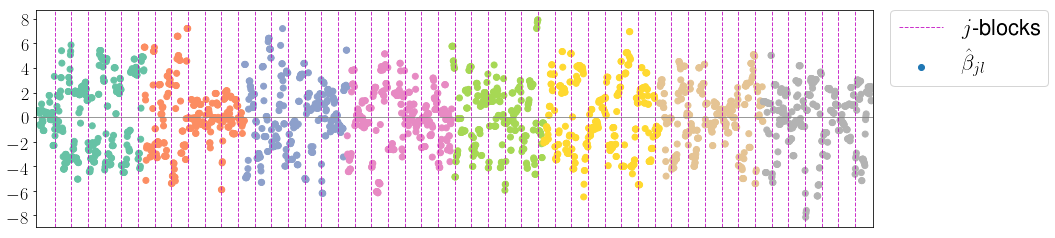

In [85]:
fig = pl.figure(figsize=(15, 4))
ax = fig.add_subplot(111)
ax.axhline(0, c='grey', alpha=.8, lw=1)
pl.scatter(range(len(coeffs)), coeffs, c=all_groups, 
           cmap='Set2', label=r"$\hat \beta_{jl}$")
ax.set_xlim([-5, len(coeffs) + 5])
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')
for i, val in enumerate(blocks_start[1:]):
    label = ''
    if i == 0:
        label = r'$j$-blocks'
    ax.axvline(val - .5, c='m', ls='--', alpha=.8, 
               lw=1, label=label)
pl.yticks(fontsize = 18)
ax.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0, fontsize=22)
if save_figures:
    pl.savefig('./figures/clustering.pdf', bbox_inches='tight')
pl.show()

### Get $b^\star$ and $\widehat{\beta^\star}$

In [86]:
right_translations, block_separation = [], []
b_star_x, b_star_y = [], []
hat_beta_star_x, hat_beta_star_y = [], []
K_star, hat_K_star = np.array([]), np.array([])
previous_max, start, start_ = 0, 0, 0
mu, mu_star, hat_mu_star = np.array([]), np.array([]), np.array([])
for j in range(n_features):
    mu_jk = boundaries[str(j)].copy()[1:-1]    
    current_min = np.min(mu_jk)
    right_translation = previous_max
    if(j > 0):
        right_translation += abs(current_min)
    right_translations += [right_translation]
    mu_jk += right_translation
    mu = np.append(mu, mu_jk)
    mu_star_j = cut_points[str(j)][1:-1] + right_translation
    if j in S:
        K_star_j = 0
    else:
        mu_star = np.append(mu_star, mu_star_j)
        K_star_j = len(mu_star_j)
    K_star = np.append(K_star, K_star_j)
    beta_star_j = beta_star[start:start + len(mu_star_j) + 1]
    start += len(mu_star_j) + 1
    b_star_x += [current_min if j==0 else previous_max]
    b_star_y += [beta_star_j[0]]
    for k in range(len(mu_star_j)):
        l_star_jk = np.argmax(np.where(mu_jk <= mu_star_j[k])) + 1
        b_star_x += [mu_jk[l_star_jk]]
        b_star_y += [beta_star_j[k + 1]]
    hat_mu_star_j = cut_points_estimates[str(j)][1:-1] + right_translation
    hat_mu_star = np.append(hat_mu_star, hat_mu_star_j)
    hat_K_star_j = len(hat_mu_star_j)
    hat_K_star = np.append(hat_K_star, hat_K_star_j)
    hat_beta_star_j = final_coeffs[start_:start_ + hat_K_star_j + 1]
    start_ += hat_K_star_j + 1
    hat_beta_star_x += [current_min if j==0 else previous_max]
    hat_beta_star_y += [hat_beta_star_j[0]]
    for k in range(hat_K_star_j):
        hat_l_jk = np.argmax(np.where(mu_jk <= hat_mu_star_j[k]))
        hat_beta_star_x += [mu_jk[hat_l_jk]]
        hat_beta_star_y += [hat_beta_star_j[k + 1]]
    previous_max = np.max(mu)
    block_separation += [previous_max]
b_star_x += [previous_max]
b_star_y = [b_star_y[0]] + b_star_y
hat_beta_star_x += [previous_max]
hat_beta_star_y = [hat_beta_star_y[0]] + hat_beta_star_y

## Auto cutoff method

In [52]:
tic = time()
epsilon = 10
auto_cutoff_rslt = auto_cutoff(X, boundaries, Y, delta, epsilon=epsilon)
tac = time()
time_auto_cutoff = tac - tic
print("\nDone estimating with auto_cutoff method in %.2e seconds." % time_auto_cutoff)


Done estimating with auto_cutoff method in 9.73e+01 seconds.


## Lausen & Schumacher correction

In [53]:
tic = time()
p_values_corr = []
for j in range(n_features):
    p_values_j = auto_cutoff_rslt[j]
    p_values_corr.append(p_value_cut(p_values_j.p_values, 
                                     p_values_j.values_to_test, X[:, j], epsilon))
tac = time()
time_L_S = tac - tic
print("\nDone Lausen & Schumacher correction in %.2e seconds." % time_L_S)


Done Lausen & Schumacher correction in 7.70e-02 seconds.


## Wild bootstrap MaxT, Dudoit & van der Laan

In [12]:
tic = time()
B = 3
adjusted_p_values_max_t = bootstrap_cut_max_t(X, boundaries, Y, delta, auto_cutoff_rslt, 
                                              B, epsilon=epsilon)
tac = time()
time_maxT = tac - tic
print("\nDone MaxT in %.2e seconds." % time_maxT)


Done MaxT in 6.54e+02 seconds.


### Estimation metrics

1) estimation of the number of cut-points: $m_1 = \frac 1 p \sum_j |\widehat{K^\star_j} - K^\star_j|$  
2) estimation of the cut-points values:  $m_2 = \frac {1}{|\mathcal{S}'|} \sum_{j\in \mathcal{S}'} \mathcal{H}(\mathcal{U}^\star_j, \widehat{\mathcal{U}^\star_j})$, where 

<ul>
    <li> $\mathcal{U}^\star_j = \{\mu^\star_{j,1}, \ldots, \mu^\star_{j,K^\star_j} \}$,</li>
    <li> $\widehat{\mathcal{U}^\star_j} = \{\widehat{\mu^\star_{j,1}}, \ldots, \widehat{\mu^\star_{j,\widehat{K^\star_j}}} \}$,</li>
    <li> $\mathcal{S}' = \big\{j,\ j \notin \mathcal{S} \cap \{l,\ \widehat{\mathcal{U}^\star_l} = \emptyset\} \big\}$,</li>
    <li> $\mathcal{H}(A, B)$ is the Hausdorff distance between the two sets $A$ and $B$, namely 
$\mathcal{H}(A, B) = \sup[\mathcal{E}(A \| B), \mathcal{E}(B \| A )]$ 
and $\mathcal{E}(A \| B) = \sup_{b\in B} \inf_{a \in A}|a - b|$.</li>
</ul>

## Results visualization

IndexError: list index out of range

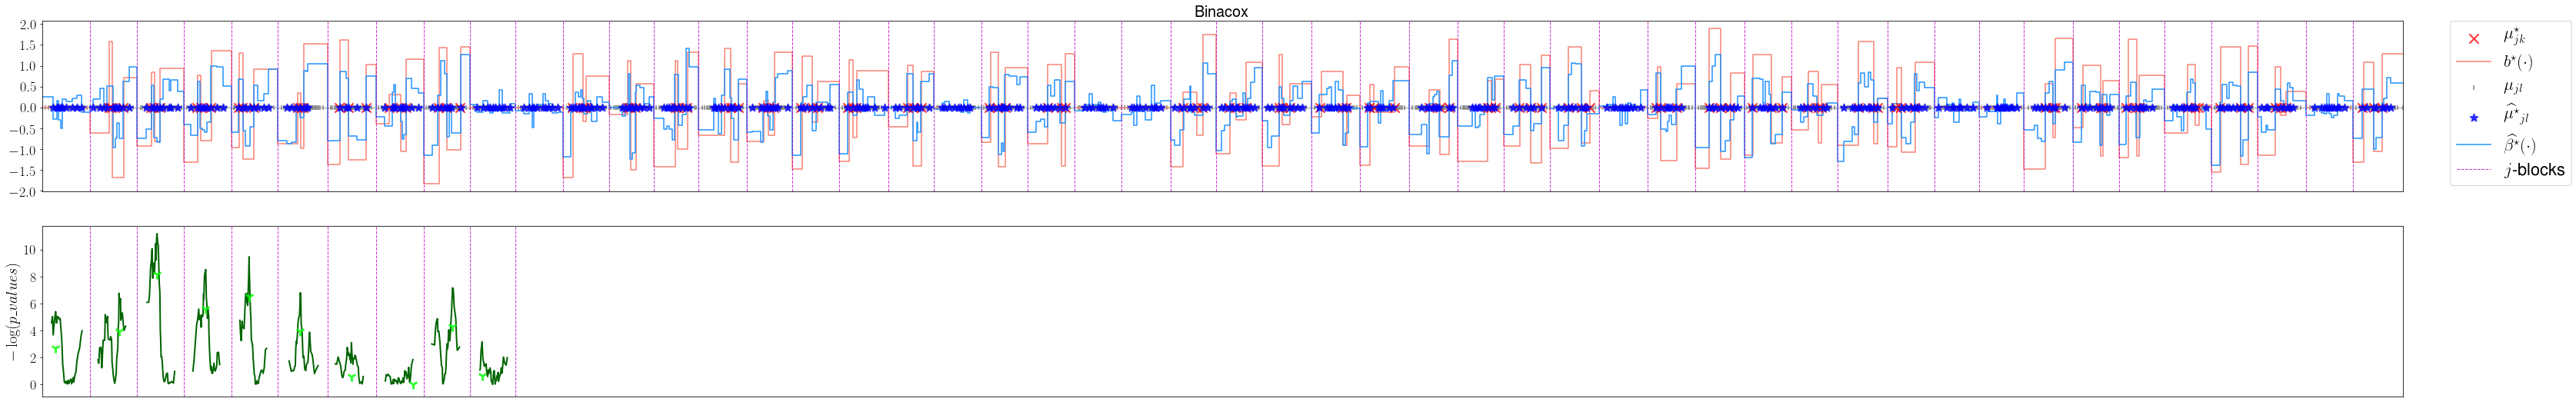

In [88]:
fig = pl.figure(figsize=(55, 9))
ax = fig.add_subplot(211)
ax.axhline(0, c='grey', alpha=.8, lw=1)
pl.step(b_star_x, b_star_y, c='salmon', label=r"$b^\star(\cdot)$")
pl.step(hat_beta_star_x, hat_beta_star_y, c='dodgerblue', 
        label=r"$\widehat{\beta^\star}(\cdot)$")
pl.scatter(mu_star, np.zeros(len(mu_star)), c='r', marker='x',
           s=150, lw=2, label=r"$\mu^\star_{jk}$", zorder=5, alpha=.8)
pl.scatter(hat_mu_star, np.zeros(len(hat_mu_star)), c='b', marker='*',
           s=100, lw=2, label=r"$\widehat{\mu^\star}_{jl}$", zorder=6, alpha=.7)
pl.scatter(mu, np.zeros(len(mu)), c='grey', marker="|",
          label=r"$\mu_{jl}$")
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')
pl.yticks(fontsize = 18)
for j in range(n_features):
    label = ''
    if j == 0:
        label = r'$j$-blocks'
    ax.axvline(block_separation[j], c='m', ls='--', 
               alpha=.8, lw=1, label=label)
    
h, l = ax.get_legend_handles_labels()
h = [h[3], h[0], h[5], h[4], h[1], h[2]]
l = [l[3], l[0], l[5], l[4], l[1], l[2]]
ax.legend(handles=h, labels=l, bbox_to_anchor=(1.02, 1), loc=2, 
          borderaxespad=0, fontsize=22)

pl.title("Binacox", fontsize=20)
ax.set_xlim([mu[0], mu[-1]])
    
ax = fig.add_subplot(212)
ax.set_xlim([mu[0], mu[-1]])
pl.tick_params(axis='x', which='both', bottom='off',
               top='off', labelbottom='off')
pl.yticks(fontsize = 18)
pl.ylabel("$-\log(p\_values)$", fontsize=20)

cut_points_estimates_ac_bonf, cut_points_estimates_ac_laus_schu = {}, {}
hat_K_star_ac_bonf, hat_K_star_ac_laus_schu = [], []
alpha = .05
for j in range(n_features):
    p_values_j = auto_cutoff_rslt[j]
    label = ''
    if j == 0:
        label = "Auto cutoff"
    ax.plot(p_values_j.values_to_test + right_translations[j], 
            -np.log(p_values_j.p_values), c='darkgreen', label=label, lw=2, zorder=3)  
    if j == 0:
        label = "P corr"
    arg_min = p_values_j.values_to_test[p_values_j.p_values.argmin()]
    pl.scatter(arg_min + right_translations[j], -np.log(p_values_corr[j]) , c='lime', 
               marker='1', s=150, lw=3, label=label, zorder=4, alpha=.8)
    
    # Bonferroni detection
    est_j = [None, None]
    n_tested = len(p_values_j.values_to_test)
    p_values_j_min = p_values_j.p_values.min()
    if p_values_j_min < alpha / n_tested:
        est_j.insert(1, p_values_j_min)
        hat_K_star_ac_bonf += [1]
    else:
        hat_K_star_ac_bonf += [0]
    cut_points_estimates_ac_bonf[str(j)] = est_j
    
    # Lausen & Schumacher detection
    est_j = [None, None]
    if p_values_corr[j] < alpha:
        est_j.insert(1, p_values_j_min)
        hat_K_star_ac_laus_schu += [1]
    else:
        hat_K_star_ac_laus_schu += [0]
    cut_points_estimates_ac_laus_schu[str(j)] = est_j
    
    if j == 0:
        label = r'$j$-blocks'
    ax.axvline(block_separation[j], c='m', ls='--', 
               alpha=.8, lw=1, label=label)
    
_, y_max = ax.get_ylim()
for j in range(n_features):
    p_values_j = auto_cutoff_rslt[j]
    
    print(p_values_j.p_values.min())
    
    label = ""
    #if j == 0:
    #    label = "MaxT"
    #log_p_values = -np.log(adjusted_p_values_max_t[j])
    #max_t_inf = p_values_j.values_to_test[log_p_values == np.inf] + right_translations[j]
    #log_p_values[log_p_values == np.inf] = y_max
    #ax.plot(p_values_j.values_to_test + right_translations[j], log_p_values, 
    #        c='mediumaquamarine', label=label, lw=2, zorder=3)
    #if j == 0:
    #    label = r"$+\infty$"
    #ax.scatter(max_t_inf, len(max_t_inf) * [y_max], c='mediumaquamarine', 
    #           marker="s", lw=3, label=label, zorder=4)
    if j == 0:
        label = "Bonferroni"
        min_val = mu[0]
    else:
        min_val = block_separation[j - 1]
    n_tested = p_values_j.values_to_test.shape[0]
    ax.axhline(-np.log(alpha/n_tested), min_val, block_separation[j], c='orange', 
               ls='-', alpha=.8, lw=2, label=label)
ax.axhline(-np.log(alpha), c='orange', ls='--', 
           alpha=.8, lw=2, label=r'$\alpha=5\%$')

h, l = ax.get_legend_handles_labels()
#h = [h[0], h[5], h[2], h[6], h[3], h[4], h[1]]
#l = [l[0], l[5], l[2], l[6], l[3], l[4], l[1]]
ax.legend(handles=h, labels=l, bbox_to_anchor=(1.02, 1), loc=2, 
          borderaxespad=0, fontsize=22) 

if save_figures:
    pl.savefig('./figures/final.pdf', bbox_inches='tight')
pl.show()

## Comparizons using metrics

In [55]:
t = PrettyTable(['Method', 'm_1', 'm_2'])
t.add_row(["BinaCox", "%.2f" % get_m_1(hat_K_star, K_star, n_features),
           "%.2e" % get_m_2(cut_points_estimates, cut_points, S)])
t.add_row(["Auto cutoff Bonferroni", "%.2f" % get_m_1(hat_K_star_ac_bonf, K_star, n_features),
           "%.2e" % get_m_2(cut_points_estimates_ac_bonf, cut_points, S)])
t.add_row(["Auto cutoff L&S", "%.2f" % get_m_1(hat_K_star_ac_laus_schu, K_star, n_features),
           "%.2e" % get_m_2(cut_points_estimates_ac_laus_schu, cut_points, S)])
print(t)

+------------------------+------+----------+
|         Method         | m_1  |   m_2    |
+------------------------+------+----------+
|        BinaCox         | 2.80 | 7.86e-01 |
| Auto cutoff Bonferroni | 1.00 | 4.18e-01 |
|    Auto cutoff L&S     | 1.00 | 4.18e-01 |
+------------------------+------+----------+


In [56]:
get_m_1(np.array(hat_K_star_ac_bonf)[S], np.array(K_star)[S], len(S))

0.0